## Library Imports ##

In [24]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')
from typing import List
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

## Data Preprocessing ##

Training data shape: (27455, 784)
Test data shape: (7172, 784)
Training labels shape: (27455, 24)
Test labels shape: (7172, 24)
Maximum count - [17]: 1294
Minimum count - [4]: 957


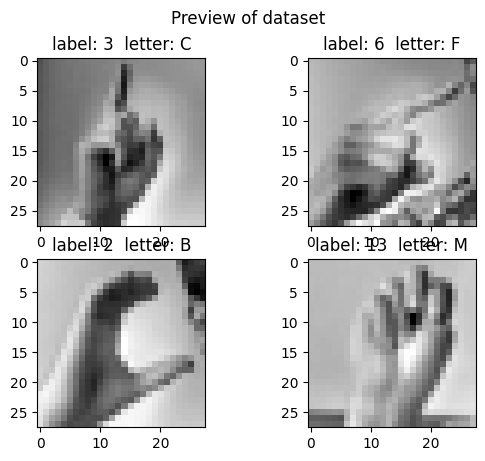

In [30]:
def preprocessing(visualize=False):
    lb=LabelBinarizer()

    # Load the training and test data
    train_df = pd.read_csv('archive/sign_mnist_train.csv')
    test_df = pd.read_csv('archive/sign_mnist_test.csv')

    # Separate features and labels
    x_train = train_df.drop('label', axis=1).values
    y_train = train_df['label'].values
    x_test = test_df.drop('label', axis=1).values
    y_test = test_df['label'].values
    
    unique_labels, label_counts = np.unique(y_train, return_counts=True)
    
    # Mean subtraction
    x_train = x_train - np.mean(x_train, axis=0)
    x_test = x_test - np.mean(x_test, axis=0)

    # Normalization 
    x_train = x_train / np.std(x_train)
    x_test = x_test / np.std(x_test)

    x_train1 =  x_train.reshape(-1,28,28,1)
    x_test1 = x_test.reshape(-1,28,28,1)

    x_train =  x_train.reshape(-1, 28*28).astype(np.float32)
    x_test = x_test.reshape(-1, 28*28).astype(np.float32)

    # Encoding the labels
    y_train = lb.fit_transform(y_train)
    y_test = lb.fit_transform(y_test)

    if (visualize==True):
    # Preview the dataset
        fig,axe=plt.subplots(2,2)
        fig.suptitle('Preview of dataset')
        axe[0,0].imshow(x_train1[0].reshape(28,28),cmap='gray')
        axe[0,0].set_title('label: 3  letter: C')
        axe[0,1].imshow(x_train1[1].reshape(28,28),cmap='gray')
        axe[0,1].set_title('label: 6  letter: F')
        axe[1,0].imshow(x_train1[2].reshape(28,28),cmap='gray')
        axe[1,0].set_title('label: 2  letter: B')
        axe[1,1].imshow(x_train1[4].reshape(28,28),cmap='gray')
        axe[1,1].set_title('label: 13  letter: M')

        # Confirm preprocessing
        print("Training data shape:", x_train.shape)
        print("Test data shape:", x_test.shape)
        print("Training labels shape:", y_train.shape)
        print("Test labels shape:", y_test.shape)

        # Print the maximum and minimum number of labels per class
        max_count = np.max(label_counts)
        min_count = np.min(label_counts)
        max_indices = np.where(label_counts == max_count)[0]
        min_indices = np.where(label_counts == min_count)[0]
        print(f"Maximum count - {unique_labels[max_indices]}: {max_count}")
        print(f"Minimum count - {unique_labels[min_indices]}: {min_count}")
    
    return x_train, y_train, x_test, y_test
    
x_train, y_train, x_test, y_test = preprocessing(visualize=False)

In [31]:
class NeuralNetLayer:
    def __init__(self):
        self.gradient = None
        self.parameters = None
       
    def forward(self, x):
        raise NotImplementedError

    def backward(self, gradient):
        raise NotImplementedError
    
class LinearLayer(NeuralNetLayer):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.ni = input_size
        self.no = output_size
        self.w = np.random.randn(output_size, input_size) * np.sqrt(2. / input_size)  # He initialization
        self.b = np.random.randn(output_size)
        self.cur_input = None
        self.parameters = [self.w, self.b]

    def forward(self, x):
        self.cur_input = x
        return x @ self.w.T + self.b

    def backward(self, gradient):
        assert self.cur_input is not None, "Must call forward before backward"
        dw = gradient.T @ self.cur_input
        db = gradient.sum(axis=0)
        self.gradient = [dw, db]
        return gradient @ self.w

class ReLULayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        self.gradient = np.where(x > 0, 1.0, 0.0)
        return np.maximum(0, x)

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient

class SoftmaxOutputLayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        self.cur_probs = None

    def forward(self, x):
        # Stabilization 
        shiftx = x - np.max(x, axis=1, keepdims=True)
        exps = np.exp(shiftx)
        probs = exps / np.sum(exps, axis=1, keepdims=True)
        self.cur_probs = probs
        return self.cur_probs

    def backward(self, target):
        assert self.cur_probs is not None, "Must call forward before backward"
        return self.cur_probs - target
class MLP:
    
    def __init__(self, *args: List[NeuralNetLayer]):
        self.layers = args

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, target):
        for layer in self.layers[::-1]:
            target = layer.backward(target)

    def fit(self, x, y, optimizer, iterations=10, batch_size=24, lambda_reg=0.0, verbose=True):
        history = {
            "loss": [],
            "accuracy": []
        }
        
        for epoch in range(iterations):
            # Shuffle the data at the beginning of each epoch
            indices = np.arange(len(x))
            np.random.shuffle(indices)
            x = x[indices]
            y = y[indices]

            # Mini-batch gradient descent
            for start_idx in range(0, len(x), batch_size):
                # Create the mini-batch
                end_idx = min(start_idx + batch_size, len(x))
                x_batch = x[start_idx:end_idx]
                y_batch = y[start_idx:end_idx]

                # Forward pass
                output = self.forward(x_batch)

                # Loss computation 
                data_loss = compute_loss(output, y_batch)
                # Regularization loss
                reg_loss = lambda_reg * sum(np.sum(layer.w ** 2) for layer in self.layers if hasattr(layer, 'w'))
                loss = data_loss + reg_loss

                # Backward pass and optimization
                self.backward(y_batch)
                optimizer.step()

                # Compute and store the loss and accuracy
                history["loss"].append(loss)
                predictions = self.predict(x_batch)
                accuracy = self.evaluate_acc(y_batch, predictions)
                history["accuracy"].append(accuracy)
                
            # Verbose output for tracking progress
            if verbose:
                print(f'Epoch {epoch + 1}/{iterations} - Loss: {np.mean(history["loss"][-len(x)//batch_size:])}, '
                      f'Accuracy: {np.mean(history["accuracy"][-len(x)//batch_size:])}')
            

        return history
    
    def predict(self, x):
        predicts = self.forward(x)
        return np.argmax(predicts, axis=1)

    def evaluate_acc(self, y_true, y_pred):
        y_true_indices = np.argmax(y_true, axis=1)
        return np.mean(y_true_indices == y_pred)

class Optimizer:
    def __init__(self, net: MLP):
        self.net = net

    def step(self):
        for layer in self.net.layers[::-1]:
            if layer.parameters is not None:
                self.update(layer.parameters, layer.gradient)

    def update(self, params, gradient):
        raise NotImplementedError
    
# For experiment 3
class RegGradientDescentOptimizer(Optimizer):
    def __init__(self, net: MLP, lr: float, lambda_reg: float):
        super().__init__(net)
        self.lr = lr
        self.lambda_reg = lambda_reg

    def update(self, params, gradient):
        for (p, g) in zip(params, gradient):
            p -= self.lr * (g + self.lambda_reg * p)

# For experiment 5            
class AdamOptimizer(Optimizer):
    def __init__(self, net: MLP, lr: float, beta1=0.9, beta2=0.999, epsilon=1e-8):
        super().__init__(net)
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = []
        self.v = []
        self.t = 0

        # Initialize moment vectors for each parameter in the network
        for layer in net.layers:
            layer_m = []
            layer_v = []
            if hasattr(layer, 'parameters') and layer.parameters:
                for param in layer.parameters:
                    layer_m.append(np.zeros_like(param))
                    layer_v.append(np.zeros_like(param))
            self.m.append(layer_m)
            self.v.append(layer_v)
    
    def update(self, layer_index, gradients):
        self.t += 1
        layer_m = self.m[layer_index]
        layer_v = self.v[layer_index]
        
        # Update the parameters of the layer
        for i, (m, v, grad) in enumerate(zip(layer_m, layer_v, gradients)):
            if grad is not None:
                m[:] = self.beta1 * m + (1 - self.beta1) * grad
                v[:] = self.beta2 * v + (1 - self.beta2) * (grad ** 2)

                # Bias correction
                m_hat = m / (1 - self.beta1 ** self.t)
                v_hat = v / (1 - self.beta2 ** self.t)

                # Update the parameter
                update_value = self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
                self.net.layers[layer_index].parameters[i] -= update_value

    # Update the parameters of the network
    def step(self):
        for i, layer in enumerate(self.net.layers):
            if hasattr(layer, 'parameters') and layer.parameters and layer.gradient:
                self.update(i, layer.gradient)
              
# For experiment 1-3
class GradientDescentOptimizer(Optimizer):
    def __init__(self, net: MLP, lr: float):
        super().__init__(net)
        self.lr = lr

    def update(self, params, gradient):
        for (p, g) in zip(params, gradient):
            p -= self.lr * g

def compute_loss(output, y_batch):
    # Assuming y_batch is a one-hot encoded matrix of labels
    m = y_batch.shape[0]  # Number of examples
    # Clipping output to avoid division by zero
    output_clipped = np.clip(output, 1e-7, 1 - 1e-7)
    # Compute cross-entropy loss
    loss = -np.sum(y_batch * np.log(output_clipped)) / m
    return loss
    

    

## Building and Training ##

In [32]:
def build_and_train_mlp(x_train, y_train, x_test, y_test, layers, units, iterations):
    """
    This function builds an MLP model with the given architecture, trains it, and evaluates its performance.
    """
    input_size = x_train.shape[-1]  # Determine the input size from the training data
    output_size = y_train.shape[-1]  # Determine the output size from the training data
    
    mlp_layers = []

    # Add the layers to the MLP model based on the specified number of layers and units
    if layers == 0:
        mlp_layers.append(LinearLayer(input_size, output_size))
    elif layers == 1:
        mlp_layers.append(LinearLayer(input_size, units))
        mlp_layers.append(ReLULayer())
        mlp_layers.append(LinearLayer(units, output_size))
    elif layers == 2:
        mlp_layers.append(LinearLayer(input_size, units))
        mlp_layers.append(ReLULayer())
        mlp_layers.append(LinearLayer(units, units))
        mlp_layers.append(ReLULayer())
        mlp_layers.append(LinearLayer(units, output_size))
    mlp_layers.append(SoftmaxOutputLayer())
    
    # Instantiate the MLP model with the specified layers
    mlp = MLP(*mlp_layers)
    
    # Train the MLP model
    optimizer = GradientDescentOptimizer(mlp, lr=0.001)
    history = mlp.fit(x_train, y_train, optimizer, iterations=iterations)
    
    # Make predictions with the trained MLP model
    y_pred = mlp.predict(x_test)
    
    # Compute the accuracy
    accuracy = mlp.evaluate_acc(y_test, y_pred)  # Adjust based on y_test format

    return accuracy, history

## Experiments ##

### Experiment 1 ###

Testing architecture: No Hidden Layer
Epoch 1/10 - Loss: 0.8617408364230091, Accuracy: 0.8731773208675383
Epoch 2/10 - Loss: 0.31828568700642407, Accuracy: 0.9776005244755245
Epoch 3/10 - Loss: 0.19807620225093564, Accuracy: 0.9928977272727273
Epoch 4/10 - Loss: 0.14102611735581394, Accuracy: 0.9981424825174825
Epoch 5/10 - Loss: 0.10903347214804343, Accuracy: 0.9994536713286714
Epoch 6/10 - Loss: 0.08873478904044742, Accuracy: 0.9997814685314685
Epoch 7/10 - Loss: 0.07494636079107503, Accuracy: 0.9998907342657343
Epoch 8/10 - Loss: 0.06489094174026182, Accuracy: 0.9998907342657343
Epoch 9/10 - Loss: 0.05723269045653124, Accuracy: 0.9998907342657343
Epoch 10/10 - Loss: 0.051252975455241795, Accuracy: 0.9999271561771562


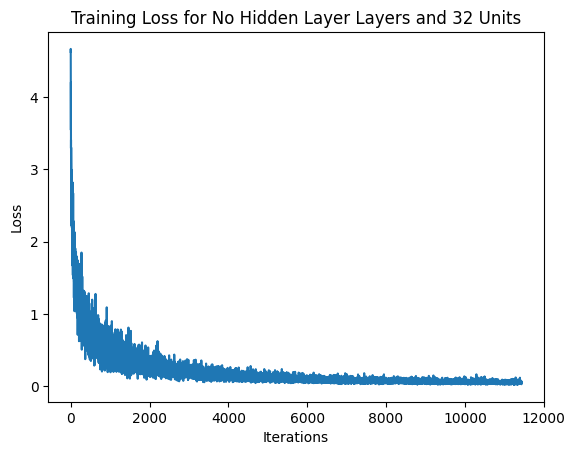

Units: 32, Test Accuracy: 0.6788901282766313

Testing architecture: No Hidden Layer
Epoch 1/10 - Loss: 0.9051013799156482, Accuracy: 0.8577344304246478
Epoch 2/10 - Loss: 0.33314779779162196, Accuracy: 0.9727928321678322
Epoch 3/10 - Loss: 0.20559614454000769, Accuracy: 0.9921328671328671
Epoch 4/10 - Loss: 0.14501994434507848, Accuracy: 0.9973776223776224
Epoch 5/10 - Loss: 0.11114863491997787, Accuracy: 0.9990530303030304
Epoch 6/10 - Loss: 0.0902148784306221, Accuracy: 0.9997814685314685
Epoch 7/10 - Loss: 0.07596194854627884, Accuracy: 0.9997086247086245
Epoch 8/10 - Loss: 0.06545775030087282, Accuracy: 0.9998178904428905
Epoch 9/10 - Loss: 0.05776826601942598, Accuracy: 0.9998543123543123
Epoch 10/10 - Loss: 0.051606901187223025, Accuracy: 0.9998907342657343


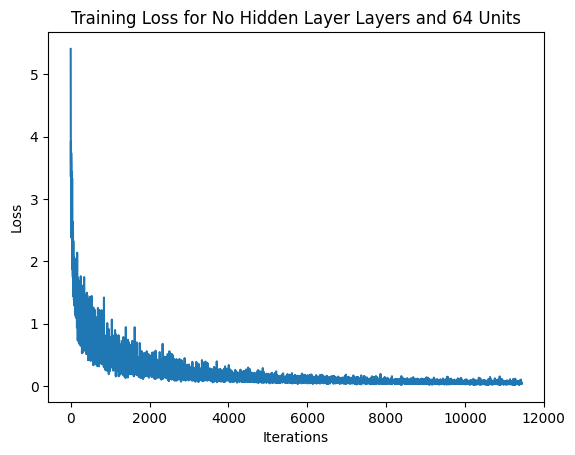

Units: 64, Test Accuracy: 0.6910206358059119

Testing architecture: No Hidden Layer
Epoch 1/10 - Loss: 0.8695928617360881, Accuracy: 0.8702968227424751
Epoch 2/10 - Loss: 0.3194353057150089, Accuracy: 0.9755608974358974
Epoch 3/10 - Loss: 0.19767356879913156, Accuracy: 0.9937354312354314
Epoch 4/10 - Loss: 0.1400112900809124, Accuracy: 0.9982517482517482
Epoch 5/10 - Loss: 0.10834146488950268, Accuracy: 0.9995265151515151
Epoch 6/10 - Loss: 0.08804236182524634, Accuracy: 0.9996722027972028
Epoch 7/10 - Loss: 0.07425653710418882, Accuracy: 0.9998178904428905
Epoch 8/10 - Loss: 0.06428991553322666, Accuracy: 0.9997450466200467
Epoch 9/10 - Loss: 0.056825298982019004, Accuracy: 0.9998543123543124
Epoch 10/10 - Loss: 0.05087112132576466, Accuracy: 0.9998543123543123


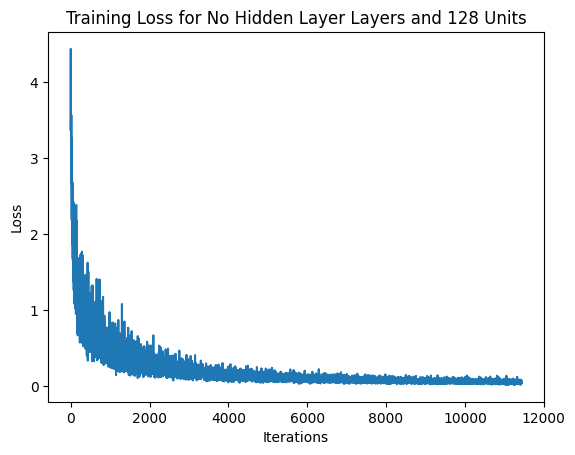

Units: 128, Test Accuracy: 0.6883714445064139

Testing architecture: No Hidden Layer
Epoch 1/10 - Loss: 0.8875844275227792, Accuracy: 0.8642191142191142
Epoch 2/10 - Loss: 0.32494039878948855, Accuracy: 0.9766171328671329
Epoch 3/10 - Loss: 0.20074642729891345, Accuracy: 0.9927520396270397
Epoch 4/10 - Loss: 0.14276055139036026, Accuracy: 0.997923951048951
Epoch 5/10 - Loss: 0.10998226874143975, Accuracy: 0.9991987179487181
Epoch 6/10 - Loss: 0.08930060190021323, Accuracy: 0.9996722027972028
Epoch 7/10 - Loss: 0.07550061817293713, Accuracy: 0.9997450466200466
Epoch 8/10 - Loss: 0.06536192687980769, Accuracy: 0.9997814685314685
Epoch 9/10 - Loss: 0.05755351909428913, Accuracy: 0.9997814685314685
Epoch 10/10 - Loss: 0.051531746820241794, Accuracy: 0.9998543123543123


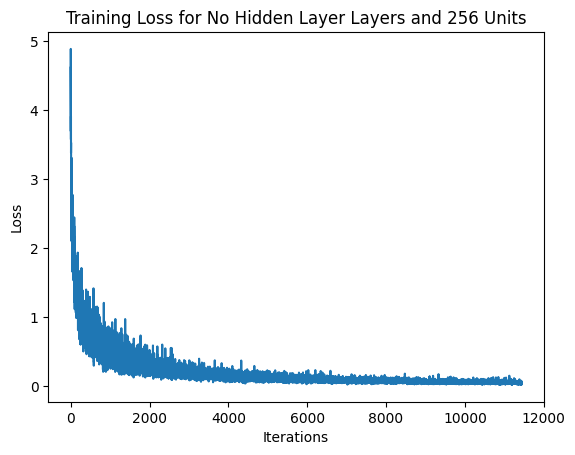

Units: 256, Test Accuracy: 0.6677356385945343

Testing architecture: One Hidden Layer
Epoch 1/10 - Loss: 0.8602774985583781, Accuracy: 0.8695731351981353
Epoch 2/10 - Loss: 0.15881334699418412, Accuracy: 0.9967948717948717
Epoch 3/10 - Loss: 0.06434533288525612, Accuracy: 0.999963578088578
Epoch 4/10 - Loss: 0.0365409758494581, Accuracy: 1.0
Epoch 5/10 - Loss: 0.024823434573522988, Accuracy: 1.0
Epoch 6/10 - Loss: 0.018443405046729328, Accuracy: 1.0
Epoch 7/10 - Loss: 0.014528303392641634, Accuracy: 1.0
Epoch 8/10 - Loss: 0.01191688777294531, Accuracy: 1.0
Epoch 9/10 - Loss: 0.010029961049998266, Accuracy: 1.0
Epoch 10/10 - Loss: 0.008654568323518328, Accuracy: 1.0


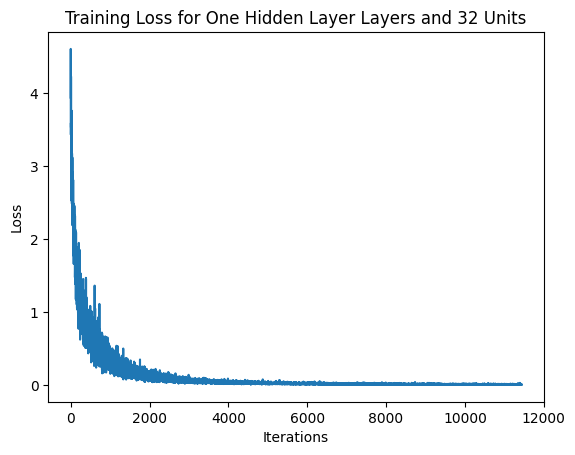

Units: 32, Test Accuracy: 0.7327105409927496

Testing architecture: One Hidden Layer
Epoch 1/10 - Loss: 0.7238651298407681, Accuracy: 0.907413917604135
Epoch 2/10 - Loss: 0.10832006973805933, Accuracy: 0.9990530303030304
Epoch 3/10 - Loss: 0.04366367112794858, Accuracy: 1.0
Epoch 4/10 - Loss: 0.02564867389725289, Accuracy: 1.0
Epoch 5/10 - Loss: 0.01777940312565464, Accuracy: 1.0
Epoch 6/10 - Loss: 0.013438744429284714, Accuracy: 1.0
Epoch 7/10 - Loss: 0.010706952268485724, Accuracy: 1.0
Epoch 8/10 - Loss: 0.00885218578941178, Accuracy: 1.0
Epoch 9/10 - Loss: 0.007530936196271502, Accuracy: 1.0
Epoch 10/10 - Loss: 0.006527778843735371, Accuracy: 1.0


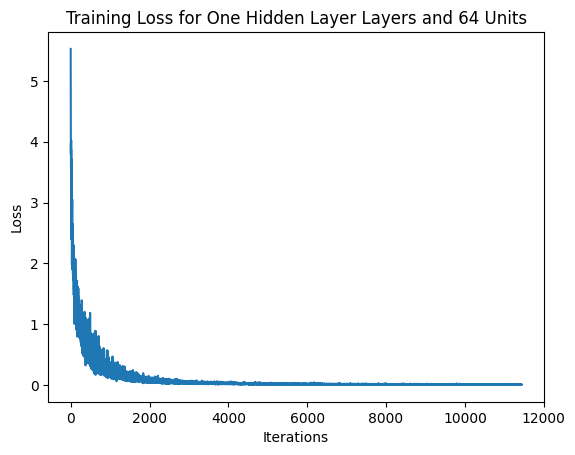

Units: 64, Test Accuracy: 0.760457334076966

Testing architecture: One Hidden Layer
Epoch 1/10 - Loss: 0.6242811027487513, Accuracy: 0.9309076340326342
Epoch 2/10 - Loss: 0.08347478958122233, Accuracy: 0.9999635780885783
Epoch 3/10 - Loss: 0.03565236893150795, Accuracy: 1.0
Epoch 4/10 - Loss: 0.02161233164837405, Accuracy: 1.0
Epoch 5/10 - Loss: 0.01520624912765872, Accuracy: 1.0
Epoch 6/10 - Loss: 0.011613562187523937, Accuracy: 1.0
Epoch 7/10 - Loss: 0.009338183453564198, Accuracy: 1.0
Epoch 8/10 - Loss: 0.007769678931234905, Accuracy: 1.0
Epoch 9/10 - Loss: 0.006622747707494305, Accuracy: 1.0
Epoch 10/10 - Loss: 0.0057662345259022595, Accuracy: 1.0


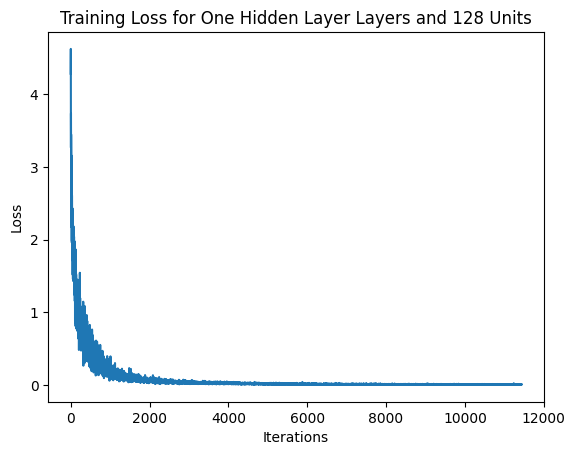

Units: 128, Test Accuracy: 0.7737032905744562

Testing architecture: One Hidden Layer
Epoch 1/10 - Loss: 0.570162392421815, Accuracy: 0.9455128205128204
Epoch 2/10 - Loss: 0.07197187353199642, Accuracy: 0.999927156177156
Epoch 3/10 - Loss: 0.031635709414673106, Accuracy: 1.0
Epoch 4/10 - Loss: 0.01948992158595185, Accuracy: 1.0
Epoch 5/10 - Loss: 0.013854327460843741, Accuracy: 1.0
Epoch 6/10 - Loss: 0.010646715816327501, Accuracy: 1.0
Epoch 7/10 - Loss: 0.008598062512403087, Accuracy: 1.0
Epoch 8/10 - Loss: 0.007179987471208043, Accuracy: 1.0
Epoch 9/10 - Loss: 0.006146027427247617, Accuracy: 1.0
Epoch 10/10 - Loss: 0.0053629521549273486, Accuracy: 1.0


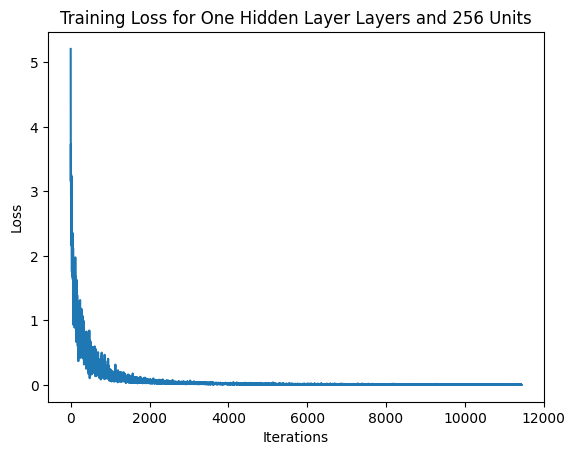

Units: 256, Test Accuracy: 0.7760736196319018

Testing architecture: Two Hidden Layers
Epoch 1/10 - Loss: 0.9662305298579179, Accuracy: 0.8389043022195196
Epoch 2/10 - Loss: 0.119782592319634, Accuracy: 0.9981060606060608
Epoch 3/10 - Loss: 0.032974711160726825, Accuracy: 0.999963578088578
Epoch 4/10 - Loss: 0.01614431369521935, Accuracy: 1.0
Epoch 5/10 - Loss: 0.010299118908905081, Accuracy: 1.0
Epoch 6/10 - Loss: 0.007422702185449493, Accuracy: 1.0
Epoch 7/10 - Loss: 0.005705824679200825, Accuracy: 1.0
Epoch 8/10 - Loss: 0.004600989332792025, Accuracy: 1.0
Epoch 9/10 - Loss: 0.003842003391441195, Accuracy: 1.0
Epoch 10/10 - Loss: 0.003264978235835976, Accuracy: 1.0


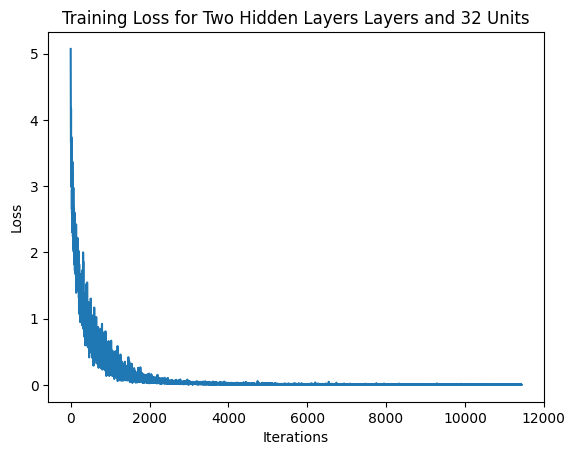

Units: 32, Test Accuracy: 0.7055214723926381

Testing architecture: Two Hidden Layers
Epoch 1/10 - Loss: 0.6574344668484116, Accuracy: 0.925590034965035
Epoch 2/10 - Loss: 0.04348251240579952, Accuracy: 1.0
Epoch 3/10 - Loss: 0.015492535247362658, Accuracy: 1.0
Epoch 4/10 - Loss: 0.008944748953945994, Accuracy: 1.0
Epoch 5/10 - Loss: 0.006153210118138242, Accuracy: 1.0
Epoch 6/10 - Loss: 0.004644246101814352, Accuracy: 1.0
Epoch 7/10 - Loss: 0.0036947526073228456, Accuracy: 1.0
Epoch 8/10 - Loss: 0.003046740852876497, Accuracy: 1.0
Epoch 9/10 - Loss: 0.0025868461422126772, Accuracy: 1.0
Epoch 10/10 - Loss: 0.0022382810784170467, Accuracy: 1.0


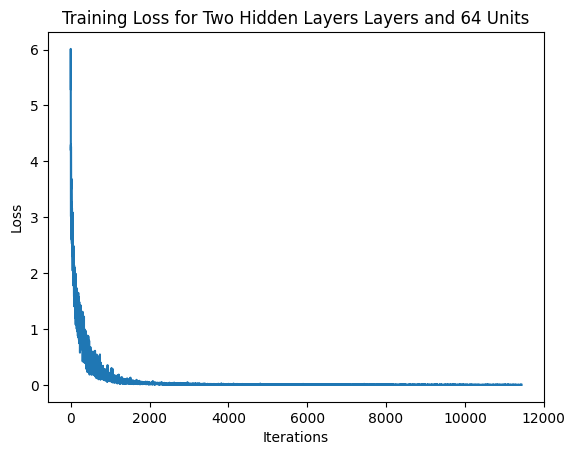

Units: 64, Test Accuracy: 0.7785833798103736

Testing architecture: Two Hidden Layers
Epoch 1/10 - Loss: 0.5415514275845973, Accuracy: 0.9511582167832168
Epoch 2/10 - Loss: 0.03368587165131883, Accuracy: 1.0
Epoch 3/10 - Loss: 0.013475785233385036, Accuracy: 1.0
Epoch 4/10 - Loss: 0.008066352685764, Accuracy: 1.0
Epoch 5/10 - Loss: 0.0056584828065648195, Accuracy: 1.0
Epoch 6/10 - Loss: 0.0042961298892827075, Accuracy: 1.0
Epoch 7/10 - Loss: 0.00343669150000301, Accuracy: 1.0
Epoch 8/10 - Loss: 0.002851232594594565, Accuracy: 1.0
Epoch 9/10 - Loss: 0.0024291697493993825, Accuracy: 1.0
Epoch 10/10 - Loss: 0.0021058207976275083, Accuracy: 1.0


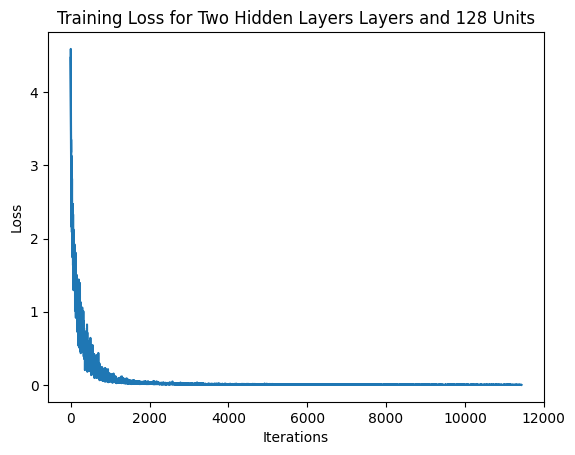

Units: 128, Test Accuracy: 0.7875069715560513

Testing architecture: Two Hidden Layers
Epoch 1/10 - Loss: 0.45563180756467836, Accuracy: 0.9674388111888111
Epoch 2/10 - Loss: 0.02575953763100528, Accuracy: 1.0
Epoch 3/10 - Loss: 0.011131184237375852, Accuracy: 1.0
Epoch 4/10 - Loss: 0.006883290453541271, Accuracy: 1.0
Epoch 5/10 - Loss: 0.0049160895815611675, Accuracy: 1.0
Epoch 6/10 - Loss: 0.0037789751025938843, Accuracy: 1.0
Epoch 7/10 - Loss: 0.0030461025795025854, Accuracy: 1.0
Epoch 8/10 - Loss: 0.0025478633250535024, Accuracy: 1.0
Epoch 9/10 - Loss: 0.002177534137849939, Accuracy: 1.0
Epoch 10/10 - Loss: 0.0018983265361048746, Accuracy: 1.0


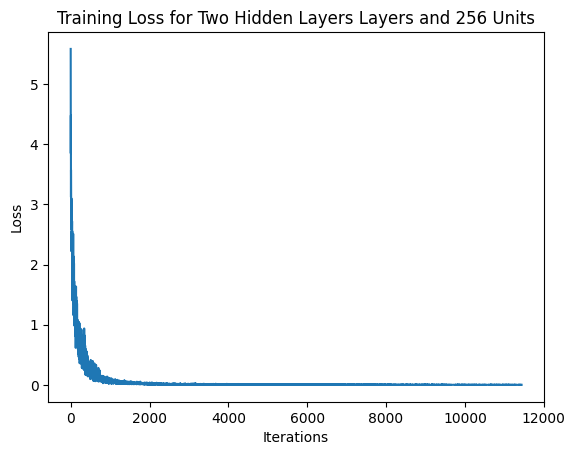

Units: 256, Test Accuracy: 0.7909927495817066

Max Accuracy: 0.7909927495817066, for Units: 256 and Layers: Two Hidden Layers


In [41]:
def experiment_1(hidden_units, hidden_layers, iterations, plot_show=False):
   
    # Results dictionary to store the accuracy for each architecture and unit configuration
    results = {}
    max_accuracy = 0
    max_accuracy_units = []
    max_accuracy_layers = []
    # Run experiments
    for layers in hidden_layers:
        arch_results = []
        for units in hidden_units:
            # If the architecture has hidden layers (is not empty)
            
            if layers == 0:
                num_layers = "No Hidden Layer"
            elif layers == 1:
                num_layers = "One Hidden Layer"
            elif layers == 2:
                num_layers = "Two Hidden Layers"

            # Print the architecture being tested for clarity
            print(f"Testing architecture: {num_layers}")
            
            # Train the model and evaluate accuracy
            accuracy, history = build_and_train_mlp(
                x_train, y_train, 
                x_test, y_test,
                layers, units,
                iterations
            )
            
            # Store and print the accuracy for the current configuration
            arch_results.append((units, accuracy))
            if accuracy > max_accuracy:
                max_accuracy = accuracy
                max_accuracy_units = units
                max_accuracy_layers = num_layers

            if plot_show:
                # Plot the training loss
                plt.plot(history['loss'])
                plt.title('Training Loss for ' + num_layers + ' Layers and ' + str(units) + ' Units')
                plt.xlabel('Iterations')
                plt.ylabel('Loss')
                plt.show()
            
            print(f"Units: {units}, Test Accuracy: {accuracy}\n")
            
        # Store the results for the current architecture
        results[str(layers)] = arch_results
    print(f"Max Accuracy: {max_accuracy}, for Units: {max_accuracy_units} and Layers: {max_accuracy_layers}")

    return results
# Experiment parameters
hidden_units = [32, 64, 128, 256]
hidden_layers = [0,1,2]
    
results = experiment_1(hidden_units, hidden_layers, iterations=10, plot_show=True)

#### Graph accuracy given the number of hidden units for each layer configuration

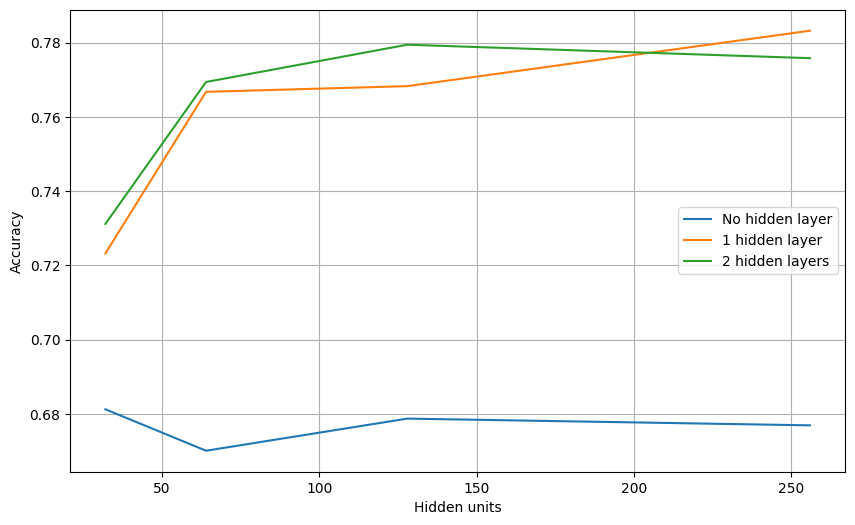

In [40]:
plt.figure(figsize=(10, 6))
labels = ["No hidden layer", "1 hidden layer", "2 hidden layers"]
for idx, (key, value) in enumerate(results.items()):
    x = [item[0] for item in value]
    y = [item[1] for item in value]
    plt.plot(x, y, label=labels[idx])

plt.xlabel('Hidden units')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### Experiment 2 ###

In [55]:
class SigmoidLayer(NeuralNetLayer):
    def forward(self, x):
        self.output = 1 / (1 + np.exp(-x))
        return self.output
    
    def backward(self, dout):
        return dout * (self.output * (1 - self.output))

class LeakyReLULayer(NeuralNetLayer):
    def __init__(self, alpha=0.2):
        super().__init__()
        self.alpha = alpha
    
    def forward(self, x):
        self.x = x
        return np.where(x > 0, x, self.alpha * x)
    
    def backward(self, dout):
        dx = np.ones_like(self.x)
        dx[self.x < 0] = self.alpha
        return dout * dx

def experiment_2(x_train, y_train, x_test, y_test, activation_layer, hidden_units=[64, 64]):
    # Construct the model architecture
    layers = [LinearLayer(x_train.shape[-1], hidden_units[0]), activation_layer()]
    for units in hidden_units[1:]:
        layers.append(LinearLayer(units, units))
        layers.append(activation_layer())
    layers.append(LinearLayer(hidden_units[-1], y_train.shape[-1]))  
    layers.append(SoftmaxOutputLayer())
    

    # Create and train the MLP model
    mlp = MLP(*layers)
    optimizer = GradientDescentOptimizer(mlp, lr=0.001)
    mlp.fit(x_train, y_train, optimizer, iterations=10)
    
    # Evaluate the model
    y_pred = mlp.predict(x_test)
    accuracy = mlp.evaluate_acc(y_test, y_pred)
    return accuracy

# Activation functions to test
activations = {
    "Sigmoid": SigmoidLayer,
    "Leaky ReLU": LeakyReLULayer,
    "ReLU": ReLULayer  
}

# Training and evaluating models with different activations
results = {}
for name, activation_layer in activations.items():
    accuracy = experiment_2(
        x_train, y_train, 
        x_test, y_test, 
        activation_layer, hidden_units=[64, 64] # 2 hidden layers with 64 units each
    )
    results[name] = accuracy
    print(f"{name} activation: Test Accuracy = {accuracy}")

Epoch 1/10 - Loss: 2.853840768729544, Accuracy: 0.2815587944664032
Epoch 2/10 - Loss: 2.1424324263212404, Accuracy: 0.5106969570284788
Epoch 3/10 - Loss: 1.6244742643065924, Accuracy: 0.6360643432654303
Epoch 4/10 - Loss: 1.2697872425641026, Accuracy: 0.7235481909394952
Epoch 5/10 - Loss: 1.0130157367833372, Accuracy: 0.7941655265024831
Epoch 6/10 - Loss: 0.8197857943726078, Accuracy: 0.8452702189115233
Epoch 7/10 - Loss: 0.6674812269925705, Accuracy: 0.8858442282355324
Epoch 8/10 - Loss: 0.5459977657382782, Accuracy: 0.918121959562177
Epoch 9/10 - Loss: 0.4472188633801581, Accuracy: 0.9413591390493564
Epoch 10/10 - Loss: 0.36731643414919596, Accuracy: 0.9599358974358974
Sigmoid activation: Test Accuracy = 0.7201617401003904
Epoch 1/10 - Loss: 0.6561174425542301, Accuracy: 0.9172129953379952
Epoch 2/10 - Loss: 0.05673451457522732, Accuracy: 1.0
Epoch 3/10 - Loss: 0.018967726133768906, Accuracy: 1.0
Epoch 4/10 - Loss: 0.010693811130157226, Accuracy: 1.0
Epoch 5/10 - Loss: 0.007269141348

#### Bar plot showing accuracy of MLP using RELU, Leaky RELU, and Sigmoid activation function

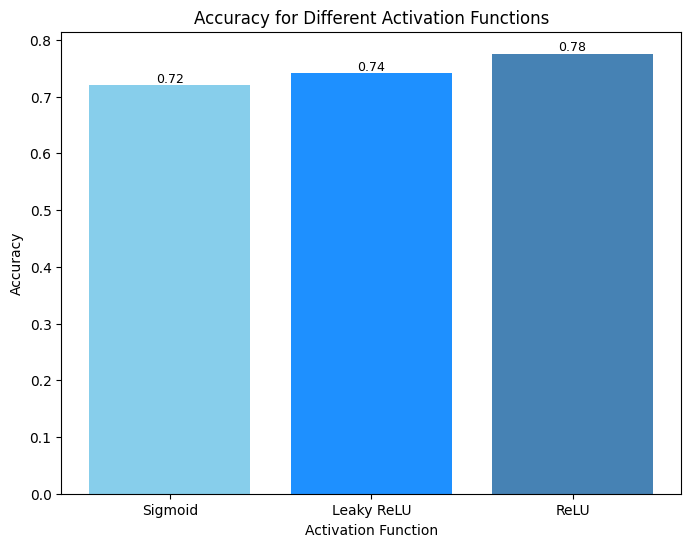

In [56]:
# Define shades of blue
colors = ['skyblue', 'dodgerblue', 'steelblue']

# Plotting
plt.figure(figsize=(8, 6))
bars = plt.bar(results.keys(), results.values(), color=colors)
plt.xlabel('Activation Function')
plt.ylabel('Accuracy')
plt.title('Accuracy for Different Activation Functions')

# Add value at the top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, '{:.2f}'.format(height),
             ha='center', va='bottom', fontsize=9)

plt.show()

### Experiment 3 ###

In [ ]:
lambdas = [0, 0.001, 0.01, 0.1, 1]  # Different values of lambda for L2 regularization
batch_size = 24 # Mini-batch size
units = 32 # Number of units in the hidden layers
for lambda_reg in lambdas:
    print(f"Training with lambda = {lambda_reg} and units = {units}")
    mlp = MLP(
        LinearLayer(x_train.shape[-1], units),
        ReLULayer(),
        LinearLayer(units, units),
        ReLULayer(),
        LinearLayer(units, y_train.shape[-1]),
        SoftmaxOutputLayer()
    )
    optimizer = RegGradientDescentOptimizer(mlp, lr=0.001, lambda_reg=lambda_reg)
    history = mlp.fit(x_train, y_train, optimizer, iterations=10, batch_size=batch_size, lambda_reg=lambda_reg)
    y_pred = mlp.predict(x_test)
    accuracy = mlp.evaluate_acc(y_test, y_pred)
    print(f"Accuracy with L2 regularization and lambda={lambda_reg}: {accuracy}")

Training with lambda = 0 and units = 32
Epoch 1/10 - Loss: 0.8341500626130264, Accuracy: 0.878314393939394
Epoch 2/10 - Loss: 0.07431273427933323, Accuracy: 0.9998543123543124
Epoch 3/10 - Loss: 0.02293384731665601, Accuracy: 1.0
Epoch 4/10 - Loss: 0.012447613251295953, Accuracy: 1.0
Epoch 5/10 - Loss: 0.008282132477331465, Accuracy: 1.0
Epoch 6/10 - Loss: 0.006093825670852934, Accuracy: 1.0
Epoch 7/10 - Loss: 0.0047693731696462575, Accuracy: 1.0
Epoch 8/10 - Loss: 0.003883584204445445, Accuracy: 1.0
Epoch 9/10 - Loss: 0.0032540093082091106, Accuracy: 1.0
Epoch 10/10 - Loss: 0.002797327543931856, Accuracy: 1.0
Accuracy with L2 regularization and lambda=0: 0.7056609035136643
Training with lambda = 0.001 and units = 32
Epoch 1/10 - Loss: 1.0691527489796462, Accuracy: 0.8689903846153845
Epoch 2/10 - Loss: 0.3302346260862555, Accuracy: 0.9996722027972028
Epoch 3/10 - Loss: 0.29433158453438885, Accuracy: 1.0
Epoch 4/10 - Loss: 0.29393331072740436, Accuracy: 1.0
Epoch 5/10 - Loss: 0.29655165

### Experiment 4 ###

In [ ]:
# Load the data
train_df = pd.read_csv('archive/sign_mnist_train.csv')
test_df = pd.read_csv('archive/sign_mnist_test.csv')

# Extract labels and features
y_train = train_df.pop('label').values
x_train = train_df.values
y_test = test_df.pop('label').values
x_test = test_df.values

# Normalize the features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train).astype(np.float32)
x_test = scaler.transform(x_test).astype(np.float32)

# Reshape the features
x_train = x_train.reshape((-1, 1, 28, 28))
x_test = x_test.reshape((-1, 1, 28, 28))

# One-hot encode labels
encoder = OneHotEncoder()
y_train = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test = encoder.transform(y_test.reshape(-1, 1)).toarray()

# Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train)
y_train_tensor = torch.tensor(y_train)
x_test_tensor = torch.tensor(x_test)
y_test_tensor = torch.tensor(y_test)

# Create PyTorch datasets and loaders
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the ConvNet model
class ConvNet(nn.Module):
    def __init__(self, hidden_units):
        super(ConvNet, self).__init__()
        # Convolutional layers
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 3 * 3, hidden_units)  # 3x3 is the spatial dimension of the output volume
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_units, 26)  # 26 classes
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

# Training and evaluation function
def train_and_evaluate_model(hidden_units):
    model = ConvNet(hidden_units)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    model.train()
    for epoch in range(10):  # 10 iterations
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.argmax(dim=1))
            loss.backward()
            optimizer.step()
            
    # Evaluate the model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.argmax(dim=1)).sum().item()

    test_acc = correct / total
    return test_acc

# Running the experiments
hidden_units_options = [32, 64, 128, 256]
results = {}
for hidden_units in hidden_units_options:
    test_acc = train_and_evaluate_model(hidden_units)
    results[hidden_units] = test_acc
    print(f"Training with {hidden_units} hidden units, Test Accuracy: {test_acc:.4f}")

#Find the best performance
best_units = max(results, key=results.get)
print(f"Best performance with {best_units} hidden units: {results[best_units]:.4f}")

Training with 32 hidden units, Test Accuracy: 0.9527
Training with 64 hidden units, Test Accuracy: 0.9650
Training with 128 hidden units, Test Accuracy: 0.9573
Training with 256 hidden units, Test Accuracy: 0.9699
Best performance with 256 hidden units: 0.9699


### Experiment 5 ### 

In [ ]:
x_train, y_train, x_test, y_test = preprocessing()

# Define the MLP architecture 
units = 256 # If you want to skip running the previous cell you can use 128 or 256
input_size = x_train.shape[-1]  # Determine the input size from the training data
output_size = y_train.shape[-1]  # Determine the output size from the training data
mlp = MLP(
    LinearLayer(input_size, units),  
    ReLULayer(),            
    LinearLayer(units, units),  
    ReLULayer(),            
    LinearLayer(units, units),  
    ReLULayer(),            
    LinearLayer(units, output_size),   
    SoftmaxOutputLayer()    
)

# Initialize the Optimizer 
adam_optimizer = AdamOptimizer(mlp, lr=0.001)

# Train the MLP model
mlp.fit(x_train, y_train, optimizer=adam_optimizer, iterations=10, verbose=True)

# Evaluate the model's performance on the test set
y_pred = mlp.predict(x_test)
accuracy = mlp.evaluate_acc(y_test, y_pred)
print(f"Test accuracy: {accuracy:.4f}")


Epoch 1/10 - Loss: 0.3947929005652796, Accuracy: 0.9357153263403265
Epoch 2/10 - Loss: 0.04930450108269618, Accuracy: 0.9974140442890443
Epoch 3/10 - Loss: 0.00020145656167068187, Accuracy: 1.0
Epoch 4/10 - Loss: 7.79718290740031e-05, Accuracy: 1.0
Epoch 5/10 - Loss: 3.9251556381190205e-05, Accuracy: 1.0
Epoch 6/10 - Loss: 2.0965178497959808e-05, Accuracy: 1.0
Epoch 7/10 - Loss: 1.1431187837812453e-05, Accuracy: 1.0
Epoch 8/10 - Loss: 6.2807222604032255e-06, Accuracy: 1.0
Epoch 9/10 - Loss: 3.4882937689912708e-06, Accuracy: 1.0
Epoch 10/10 - Loss: 1.915632209287589e-06, Accuracy: 1.0
Test accuracy: 0.8341
